### Kaggle CNN 期中考連結  
https://www.kaggle.com/t/2d1cbb1050804f9aa683589b9ee66e46

In [1]:
# import package
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, Activation,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization,concatenate,Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.inception_v3 import InceptionV3 , preprocess_input
from tensorflow.keras.layers import Input, concatenate
#from tensorflow.keras.applications.densenet import DenseNet121 , preprocess_input
from tensorflow.keras.applications.xception import Xception , preprocess_input

In [2]:
! nvidia-smi

Mon Jan 16 23:06:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    20W / 350W |    716MiB / 24576MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 一、讀取與處理

## 1. 基本超參數

In [3]:
#!unzip -qq innolux-tainan5-cnn.zip

In [4]:
image_size = (299,299)  # 圖片大小
batch_size = 32  # batch_size
Epoch = 20  # Epoch (本次考試限定使用 20 個 epoch 做訓練)
Trainloc = './Dataset/Train/'  # 訓練集路徑

In [5]:
# 預設資料集就是與此notebook檔案同樣的路徑底下
# data_dir = './'
# data_path = os.path.join(data_dir, 'Dataset/')
data_path = Trainloc

# 先確定好模型儲存的路徑，預設儲存在與notebook檔案同樣的路徑底下
model_dir = './model-logs/CNN_Exam'
model_folder = './model-logs2'

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# save model
modelfiles = model_dir + '/model.h5'

## 2. 建立資料集

In [6]:
def DirToDataFrame(data_path):
    x_data_list = []
    y_data_list = []

    for dir in os.listdir(data_path):
        for img in os.listdir(os.path.join(data_path,dir)):
            x_data_list.append(os.path.join(dir,img))
            y_data_list.append(dir)

    data_list = pd.DataFrame({})
    data_list['img_path'] = x_data_list
    data_list['label'] = y_data_list
    return data_list

In [7]:
DataList = DirToDataFrame(Trainloc)
DataList

In [9]:
print(DataList.groupby('label').size().sort_values())

label
buildings    2118
glacier      2224
sea          2255
forest       2267
street       2379
mountain     2507
dtype: int64


## 3. 切割成訓練集與驗證集

In [10]:
from sklearn.model_selection import train_test_split

Train_list, Val_list = train_test_split(DataList,
                                        # 這個測試集數量可以自己設定，不一定要8 : 2，這邊只是一個範例
                                        test_size=0.01,
                                        random_state=42,
                                        #按比例分配，如Labela, Labelb的比例是2:1, 則train and test的 Labela, Labelb的比例都會是2:1
                                        stratify=DataList['label'].values,
                                        shuffle = True)
print(len(Train_list),len(Val_list))


13612 138


# 二、查看圖片

forest\2674.jpg


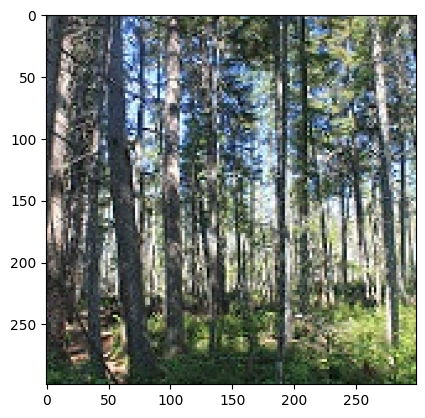

In [11]:
Num = randint(0,len(Train_list)-1)
image = tf.keras.preprocessing.image.load_img(Trainloc+'/'+Train_list.iloc[Num].img_path,
                                            grayscale=False, 
                                            color_mode='rgb', 
                                            target_size=image_size)
plt.imshow(image)
print(Train_list.iloc[Num].img_path)

# 三、 隨機查看多張訓練集圖片

In [12]:
#隨機查看圖片
def ShowImage(imagesdir,imgdataframe,total=10): #圖片，標籤，預測標籤，總共顯示張數
    plt.gcf().set_size_inches(18, 20)
    if total >=25:
        total = 25
    for i in range(0,total):
        num = randint(0,len(imgdataframe)-1)
        img_show = plt.subplot(5, 5, i+1)
        Img = tf.keras.preprocessing.image.load_img(imagesdir+'/'+imgdataframe.iloc[num].img_path,
                                            grayscale=False, 
                                            color_mode='rgb', 
                                            target_size=image_size)
        img_show.imshow(Img)
        title = "label = "+str(imgdataframe.iloc[num].label)
        plt.title(title)
    plt.show()
#ShowImage(Trainloc,Train_list,total=25)


# 四、 Image Generator

## 1. 設計訓練集與驗證集的ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [13]:
# 這裡千萬要記得，訓練集可以做一些資料擴增的手法，但驗證集不行
# 記得要設計資料預處理的方法，如：Min Max Rescale

train_datagen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=.15,
                                  height_shift_range=.15,
                                  shear_range=0.15,
                                  zoom_range=0.15,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
data_path

'./Dataset/Train/'

## 2. 設計訓練集與驗證集的Data Generator

https://keras.io/zh/preprocessing/image/

In [15]:
train_generator = train_datagen.flow_from_dataframe(dataframe = Train_list,
    directory = data_path,
    x_col = 'img_path',
    y_col = 'label',
    color_mode='rgb',
    target_size = image_size,
    batch_size = batch_size,
    suffle = True,
    class_mode = 'categorical' )


val_generator = val_datagen.flow_from_dataframe(dataframe = Val_list,
    directory = data_path,
    x_col = 'img_path',
    y_col = 'label',
    color_mode='rgb',
    target_size = image_size,
    batch_size = batch_size,
    suffle = False,
    class_mode = 'categorical' )


Found 13612 validated image filenames belonging to 6 classes.
Found 138 validated image filenames belonging to 6 classes.


## 3. 取出Generator生成出來的標籤檔案(dictionary)

In [16]:
label = train_generator.class_indices
num_classes = len(label)
labelreverse = {v: k for k, v in label.items()}
labelreverse

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

# 六、 模型架構

## Main Model

這邊請設計自己的模型，記得要有 input layer 與最後的 output layer

In [17]:
#Get DenseNet121 convolution layer only, include_top false
from tensorflow.keras import regularizers
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Replace BatchNormalization layers with this new layer.
    This layer has fixed momentum 0.9.
    """
    def __init__(self, momentum=0.9, name=None, **kwargs):
        super(BatchNormalization, self).__init__(momentum=0.9, name=name, **kwargs)

    def call(self, inputs, training=None):
        return super().call(inputs=inputs, training=training)

    def get_config(self):
        config = super(BatchNormalization, self).get_config()
        return config

tf.keras.layers.BatchNormalization = BatchNormalization

pre_model = Xception(weights='imagenet', include_top=False,
                     input_shape=(*image_size, 3))

#for layer in pre_model.layers:
    
    #layer.trainable=False

# Do GlobalAveragePooling2D
x = GlobalAveragePooling2D()(pre_model.output)

# Dense layer
x = Dense(512,activation='relu')(x)
          #kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          #bias_regularizer=regularizers.L2(1e-4),
          #activity_regularizer=regularizers.L2(1e-5))(x)
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)

# Drop out
x = Dropout(0.5)(x)

#Output layer

outputs = Dense(len(label), activation='softmax')(x)

# set up a model structure#
model = Model(inputs=pre_model.inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

# 七、 model compile

In [18]:
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
title = [k for k, v in label.items()]
labels_count = DataList['label'].value_counts()

weight = np.zeros(len(title))
class_sum = 0
for name in title:
    class_sum += labels_count[name]
    weight_idx = train_generator.class_indices[name]
    weight[weight_idx] = 1 / (len(title) * labels_count[name])

weight = weight * class_sum
weight = {i:weight[i] for i in range(len(title))}
print(weight)

{0: 1.081995593327038, 1: 1.0108807528304662, 2: 1.030425659472422, 3: 0.9141071666001861, 4: 1.016260162601626, 5: 0.9632898977161273}


In [19]:
from tensorflow_addons.optimizers import AdamW
# 編譯模型
# 選用Adam為optimizer
learning_rate = 2e-5
optimizer = AdamW(learning_rate=learning_rate , weight_decay=0.0001)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', "Precision", "Recall"])

# 八、 Call Back Function

## 這裡請設計想要的Call back Function

如：Early stopping, 模型的儲存...等

In [20]:
model_mckp = tf.keras.callbacks.ModelCheckpoint(modelfiles,
                                                monitor='val_accuracy',
                                                save_best_only=True)
# set earlystop

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', #early stop時，用什麼function當標準
                        patience=5,  #幾次都沒有提升的話就結束
                        verbose=1)


callbacks_list = [model_mckp,earlystop]

# 九、模型訓練

In [21]:
#Training
history = model.fit(train_generator,
          epochs = Epoch,
          shuffle = True, 
          callbacks=callbacks_list,
          class_weight = weight,
          validation_data=val_generator,)

Epoch 1/20
426/426 [==============================] - 169s 384ms/step - loss: 0.8625 - accuracy: 0.7091 - precision: 0.9212 - recall: 0.4838 - val_loss: 0.2378 - val_accuracy: 0.9203 - val_precision: 0.9248 - val_recall: 0.8913
Epoch 2/20
426/426 [==============================] - 164s 385ms/step - loss: 0.2686 - accuracy: 0.9180 - precision: 0.9331 - recall: 0.9006 - val_loss: 0.1856 - val_accuracy: 0.9348 - val_precision: 0.9412 - val_recall: 0.9275
Epoch 3/20
426/426 [==============================] - 163s 382ms/step - loss: 0.2029 - accuracy: 0.9373 - precision: 0.9453 - recall: 0.9284 - val_loss: 0.1784 - val_accuracy: 0.9420 - val_precision: 0.9489 - val_recall: 0.9420
Epoch 4/20
426/426 [==============================] - 165s 386ms/step - loss: 0.1725 - accuracy: 0.9459 - precision: 0.9519 - recall: 0.9395 - val_loss: 0.1532 - val_accuracy: 0.9638 - val_precision: 0.9638 - val_recall: 0.9638
Epoch 5/20
426/426 [==============================] - 165s 387ms/step - loss: 0.1479 - a

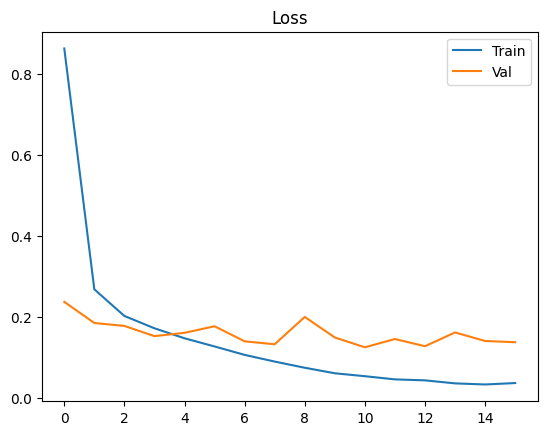

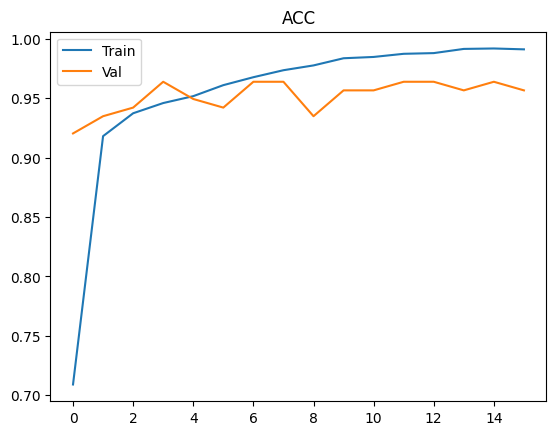

In [22]:
training_loss, val_loss = history.history['loss'], history.history['val_loss']

plt.title('Loss')
plt.plot(training_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.legend()
plt.show()

training_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

plt.title('ACC')
plt.plot(training_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.show()

# 十、 Predict Testing Set

## 1. 讀取訓練好的模型

In [23]:
best_model = load_model(modelfiles)

## 2. 讀取Sample CSV，用來預測測試集

In [24]:
Testingdataloc = './Dataset/test/' # 測試集的路徑

Samplesubmission = './Dataset/sample_submission.csv'    # Sample Submission.csv檔案(使用這個檔案來去預測測試集)
Sampledf = pd.read_csv(Samplesubmission)
Sampledf

,file_path,pred
0,0.jpg,glacier
1,1.jpg,glacier
2,10.jpg,glacier
3,100.jpg,glacier
4,1000.jpg,glacier
...,...,...
2996,995.jpg,glacier
2997,996.jpg,glacier
2998,997.jpg,glacier
2999,998.jpg,glacier


## 3. 測試集的ImageDatagenerator 與 Datagenerator

In [25]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [26]:
test_generator = test_datagen.flow_from_dataframe(dataframe = Sampledf,
                                    directory = Testingdataloc,
                                    x_col = 'file_path',
                                    y_col = 'pred',
                                    color_mode='rgb',
                                    batch_size=batch_size,            
                                    target_size = image_size,
                                    class_mode = None,
                                    shuffle=False)

Found 3001 validated image filenames.


## 4. 將test_generator去進行predict，將預測的結果儲存在Predict_output中

In [27]:
Predict_output = model.predict(test_generator, verbose = 1)

94/94 [==============================] - 6s 60ms/step


## 5. Predict_output找出每一筆測試圖片的最大值index結果（softmax最大值的index）

In [28]:
output = np.argmax(Predict_output, axis=1)

## 6. 將Predict_output轉換成文字標籤

In [29]:
title = [k for k, v in label.items()]
print(title)
PredictY = []
for i in range(len(Predict_output)):
    PredictY.append(title[output[i]])
    
    # 將每一筆的 Predict_output 的結果轉換成文字標籤，並儲存在 PredictY 陣列中
print(PredictY)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
['glacier', 'street', 'glacier', 'sea', 'buildings', 'buildings', 'sea', 'sea', 'sea', 'street', 'forest', 'street', 'street', 'glacier', 'sea', 'glacier', 'street', 'street', 'mountain', 'street', 'mountain', 'glacier', 'mountain', 'sea', 'sea', 'glacier', 'glacier', 'street', 'street', 'buildings', 'forest', 'glacier', 'forest', 'forest', 'glacier', 'mountain', 'forest', 'forest', 'forest', 'buildings', 'buildings', 'mountain', 'buildings', 'sea', 'forest', 'street', 'mountain', 'buildings', 'glacier', 'forest', 'mountain', 'street', 'buildings', 'sea', 'street', 'street', 'sea', 'glacier', 'street', 'sea', 'sea', 'glacier', 'street', 'glacier', 'sea', 'forest', 'glacier', 'glacier', 'sea', 'sea', 'glacier', 'street', 'sea', 'buildings', 'mountain', 'forest', 'buildings', 'buildings', 'forest', 'mountain', 'mountain', 'street', 'mountain', 'forest', 'buildings', 'forest', 'sea', 'street', 'forest', 'glacier', 'forest', '

## 7. 將預測結果儲存成dataframe, 'File'：原本Sampledf的圖片檔名（不用改）, 'Label'：預測標籤結果

In [30]:
SampleSubmission = pd.DataFrame({})
SampleSubmission['file_path'] = Sampledf['file_path']
SampleSubmission['pred'] = PredictY
SampleSubmission

,file_path,pred
0,0.jpg,glacier
1,1.jpg,street
2,10.jpg,glacier
3,100.jpg,sea
4,1000.jpg,buildings
...,...,...
2996,995.jpg,glacier
2997,996.jpg,mountain
2998,997.jpg,sea
2999,998.jpg,sea


## 8.將dataframe儲存成kaggle可以上傳的csv檔案

In [31]:
SampleSubmission.to_csv('Submission.csv',index = False)